# Espace Note

In [ ]:
# regarder si des couleurs sont atypiques attirent des comportements atypiques chez certains clients

# établir une répartition des types d'articles achetés dans la période de l'année où l'on doit faire
# la prédiction. Il faut faire de même pour les couleurs de saison et vérifier si elles sont différentes
# d'une année sur l'autre pour évaluer la mode. Il faut aussi voir la couleur à la mode pour l'année

# établir le profil des clients en fonction des types d'objets achetés. Puis par série ou non ?

# établir une liste des articles qui s'achètent en simple, double, triple

In [ ]:
# Hypothèse 1 On va retirer les clients qui commandent plus que 99% de clients

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Espace travail

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time 
import sys
import csv
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
os.chdir('drive/MyDrive/Formation/Projet 8')

In [ ]:
pickle_in = open('sample_cust_df.pickle','rb')
sample_cust_df = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('df_info.pickle','rb')
df_info = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('df_sample_cust.pickle','rb')
df_sample_cust = pickle.load(pickle_in)
pickle_in.close()
# pickle_in = open('df_sample.pickle','rb')
# df_sample = pickle.load(pickle_in)
# pickle_in.close()

In [354]:
meta_art = pd.read_csv('articles.csv',dtype={'article_id': str})
meta_cust = pd.read_csv('customers.csv')
sub_format = pd.read_csv('sample_submission.csv')
df = pd.read_csv('transactions_train.csv',dtype={'article_id': str})

In [ ]:
df['sales_channel_id'] = df['sales_channel_id'].astype('int8')

In [ ]:
meta_art.drop([
               'graphical_appearance_no','product_type_no','colour_group_code',\
               'index_code','index_group_no','product_code',\
               'perceived_colour_value_id','perceived_colour_master_id',\
               'department_no','section_no','garment_group_no'],\
              axis=1,inplace=True)

In [ ]:
# Calculating the threshold of number of orders max to represent 99% of the pop
# The last remaining 1% orders much more than the average customer and will be 
# removed from data to quicken the runtimes
nb_orders = df.groupby('customer_id')['t_dat'].nunique()
seuil = 0.0
nb_purchase = 0
while seuil < 0.99:
    nb_purchase += 1
    seuil=len(nb_orders[nb_orders<(nb_purchase+1)])/len(nb_orders)
print(nb_purchase)
cust_too_many_commands =nb_orders[nb_orders>nb_purchase].index
df = df[~df['customer_id'].isin(cust_too_many_commands)]

45


# Definition of the first time client: How can we do better than randomly chosing an article

In [236]:
# we make a list of the 12 most populars items as we can predict up to 12 items
# for a customer with no penalty
most_bought_2020 = df[df['t_dat'] > '2020-08-22'].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12)


# Pattern related to the time of the year

In [ ]:
df_info = df.merge(meta_art,how='left',on='article_id')

In [ ]:
# we are making our tests on 10000 customers
# we create the dataframe that will hold the information of customers
# we create the sub DataFrame of these customers df_sample

random.seed(123)
sample_cust = random.sample(set(df_info['customer_id']),k = 10000)
sample_cust_df = pd.DataFrame(index=sample_cust)
df_sample = df_info[df_info['customer_id'].isin(sample_cust)]
sample_cust_df['customer_id']=sample_cust_df.index

In [ ]:
# list of colour previously bought
# nb of purchases over the 2 years
# type of clothing purchases

sample_cust_df['colour_bought'] = df_sample.groupby('customer_id')\
['perceived_colour_master_name'].unique()
sample_cust_df['nb_purchase'] = df_sample.groupby('customer_id')\
['article_id'].count()
sample_cust_df['type_of_clothing'] = df_sample.groupby('customer_id')\
['product_group_name'].unique()
sample_cust_df['appearance'] = df_sample.groupby('customer_id')\
['graphical_appearance_name'].unique()

In [ ]:
# the goal here is to make a conformity score, to see if the customer buys the
# most popular 'something' (colour,type of clothing)
def conformity_score(category):
  sample_cust_df['conformity_'+category] = 0
  col_fr = df_info[category].value_counts(normalize=True)
  t0=time()
  for count,cust in enumerate(sample_cust_df.index):  
    conf = 0
    df_temp = df_sample[df_sample['customer_id']==cust]
    for colour in col_fr.index:
      conf = conf + float(((df_temp[category]==colour).sum()))*float(col_fr[col_fr.index==colour])    
    conf = conf/float(sample_cust_df[sample_cust_df.index==cust]['nb_purchase'])  
    sample_cust_df.loc[cust,'conformity_'+category]=conf 

#took 6 minutes like must be a way to improve the speed

In [ ]:
conformity_score('perceived_colour_master_name')
conformity_score('product_group_name')
conformity_score('graphical_appearance_name')
sample_cust_df['conformity_perceived_colour_master_name'] = sample_cust_df['conformity_perceived_colour_master_name']/sample_cust_df['conformity_perceived_colour_master_name'].mean()
sample_cust_df['conformity_product_group_name'] = sample_cust_df['conformity_product_group_name']/sample_cust_df['conformity_product_group_name'].mean()
sample_cust_df['conformity_graphical_appearance_name'] = sample_cust_df['conformity_graphical_appearance_name']/sample_cust_df['conformity_graphical_appearance_name'].mean()
# a value higher than 1, means that the customer is buying the most standard articles and a value below means the customer is buying least standard articles

In [ ]:
sample_cust_df['average_buy'] = df_sample.groupby('customer_id')['price'].mean()
sample_cust_df['std_buy'] = df_sample.groupby('customer_id')['price'].std()
sample_cust_df['max_budget'] = df_sample.groupby('customer_id')['price'].max()

In [ ]:
df_temp_Y = pd.DataFrame(df_sample[df_sample['t_dat'] >'2020-09-14'])
df_3_weeks = df_info[(df_info['t_dat']>'2020-09-01')&(df_info['t_dat']<='2020-09-14')]

In [ ]:
def article_selection(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_cust_df.loc[cust,'max_budget']]
    # we remove articles with perceived colour never bought by the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_cust_df.loc[cust,'colour_bought']))]['article_id']))
    # we remove articles out of the product group of the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_cust_df.loc[cust,'type_of_clothing']))]['article_id']))
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_cust_df.loc[cust,'appearance']))]['article_id']))   
    temp_list1 = temp_list.intersection(set(actually_bought))
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [ ]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  wide_list_popular_item_df['price_estimated']=0
  for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      article_selection)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list

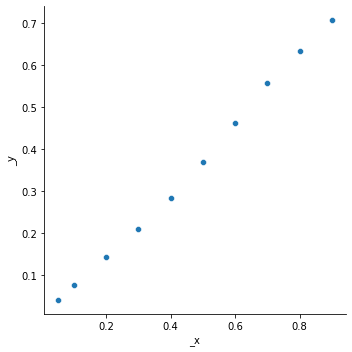

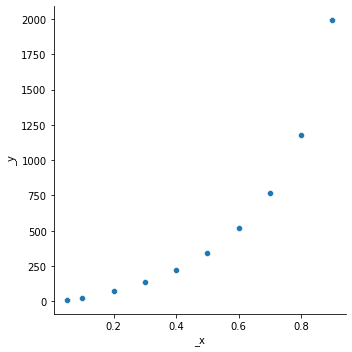

In [ ]:
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

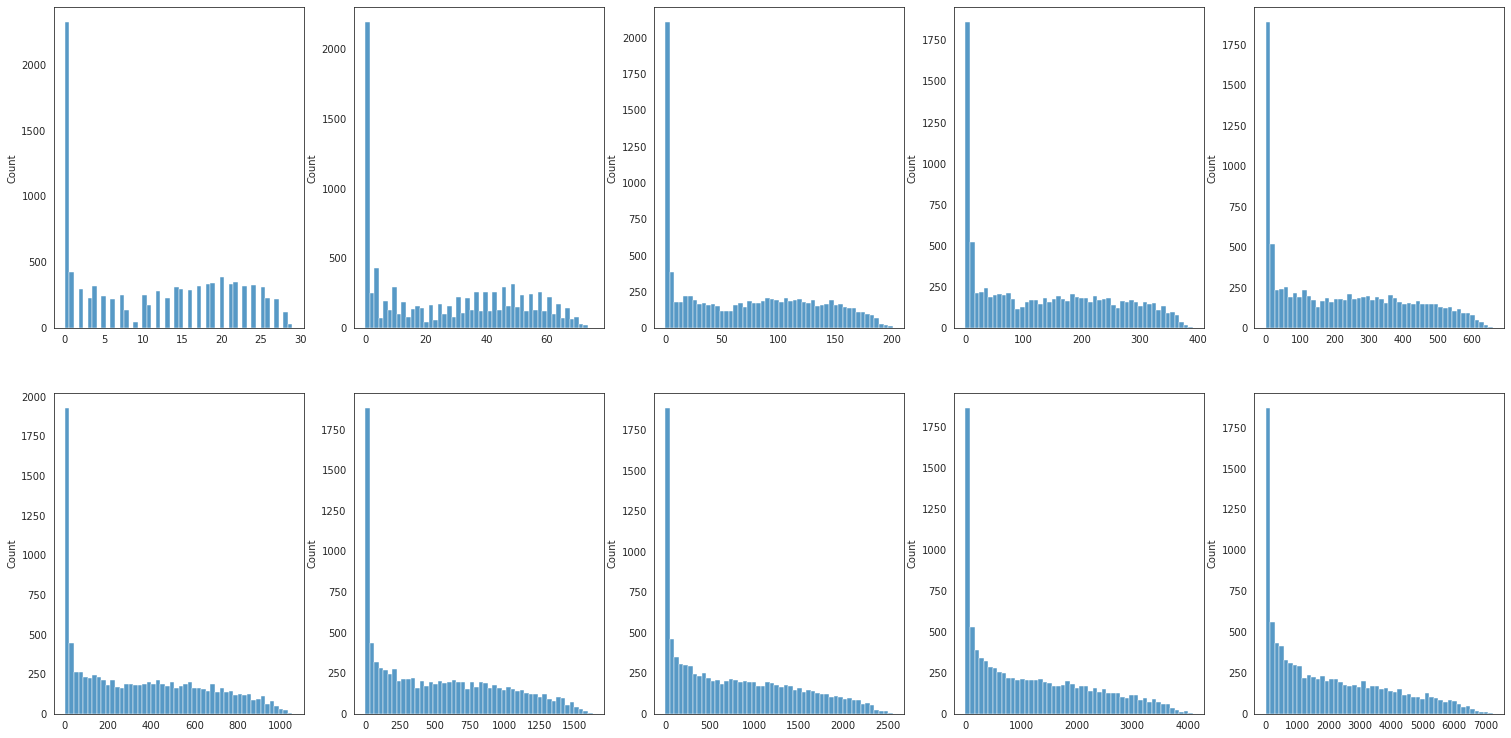

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [ ]:
def art_sel_budget(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_cust_df.loc[cust,'max_budget']] 
    temp_list1 = set(temp_list.index).intersection(set(actually_bought))
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))   

In [ ]:
def art_sel_colour(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_cust_df.loc[cust,'colour_bought']))]['article_id'])) 
    temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [ ]:
def art_sel_typecloth(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    # we remove articles out of the product group of the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_cust_df.loc[cust,'type_of_clothing']))]['article_id']))      
    temp_list1 = temp_list.intersection(set(actually_bought))    
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [ ]:
def art_sel_appearance(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_cust_df.loc[cust,'appearance']))]['article_id']))   
    temp_list1 = temp_list.intersection(set(actually_bought))   
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))  

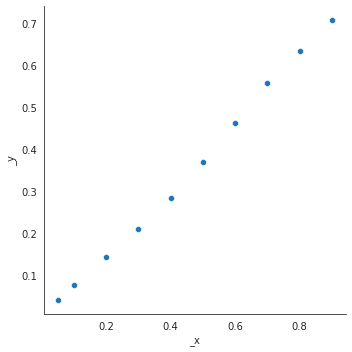

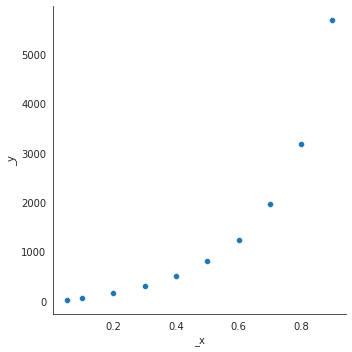

In [ ]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  wide_list_popular_item_df['price_estimated'] = 0
  for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers. We divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list. we calculate c2 the number of articles
  # in our restricted list on average we calculate c3, the distribution of
  # of number of restricted articles per customer.
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_budget)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

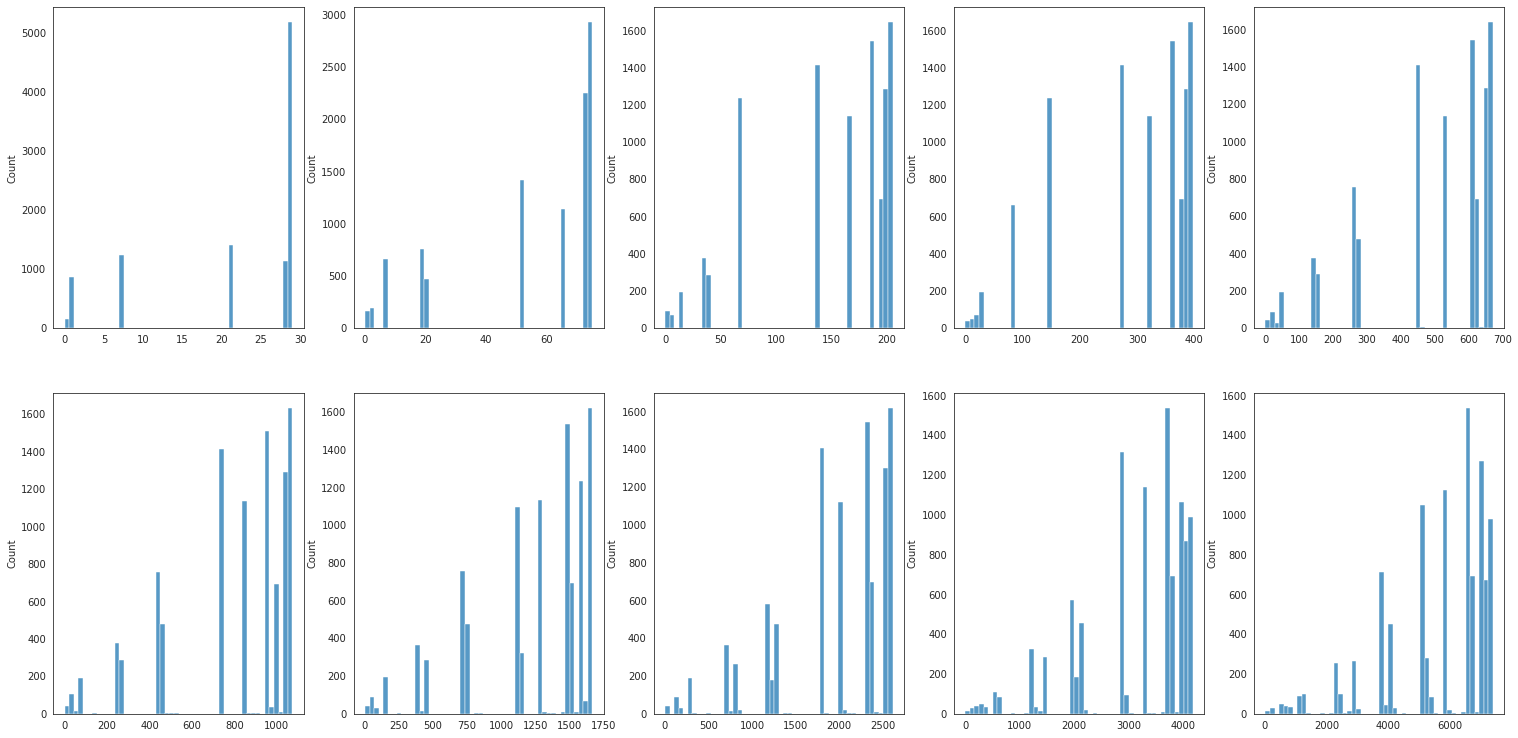

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [ ]:
count1

[0.0416221985058698,
 0.07630736392742796,
 0.14461045891141944,
 0.21077908217716115,
 0.2833511205976521,
 0.3697972251867663,
 0.4615795090715048,
 0.5570971184631803,
 0.6334044823906083,
 0.7065101387406617]

In [ ]:
count2

[22.1462,
 55.8667,
 150.9396,
 296.8067,
 501.0315,
 803.7557,
 1241.8994,
 1972.0479,
 3181.4085,
 5683.4514]

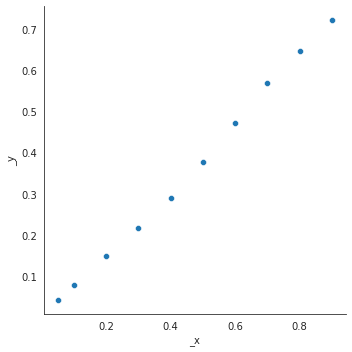

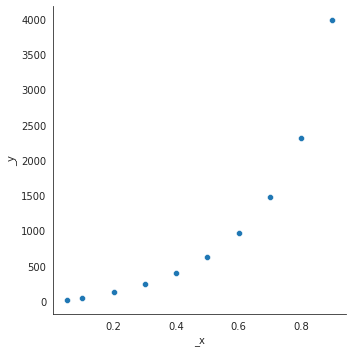

In [ ]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_colour)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

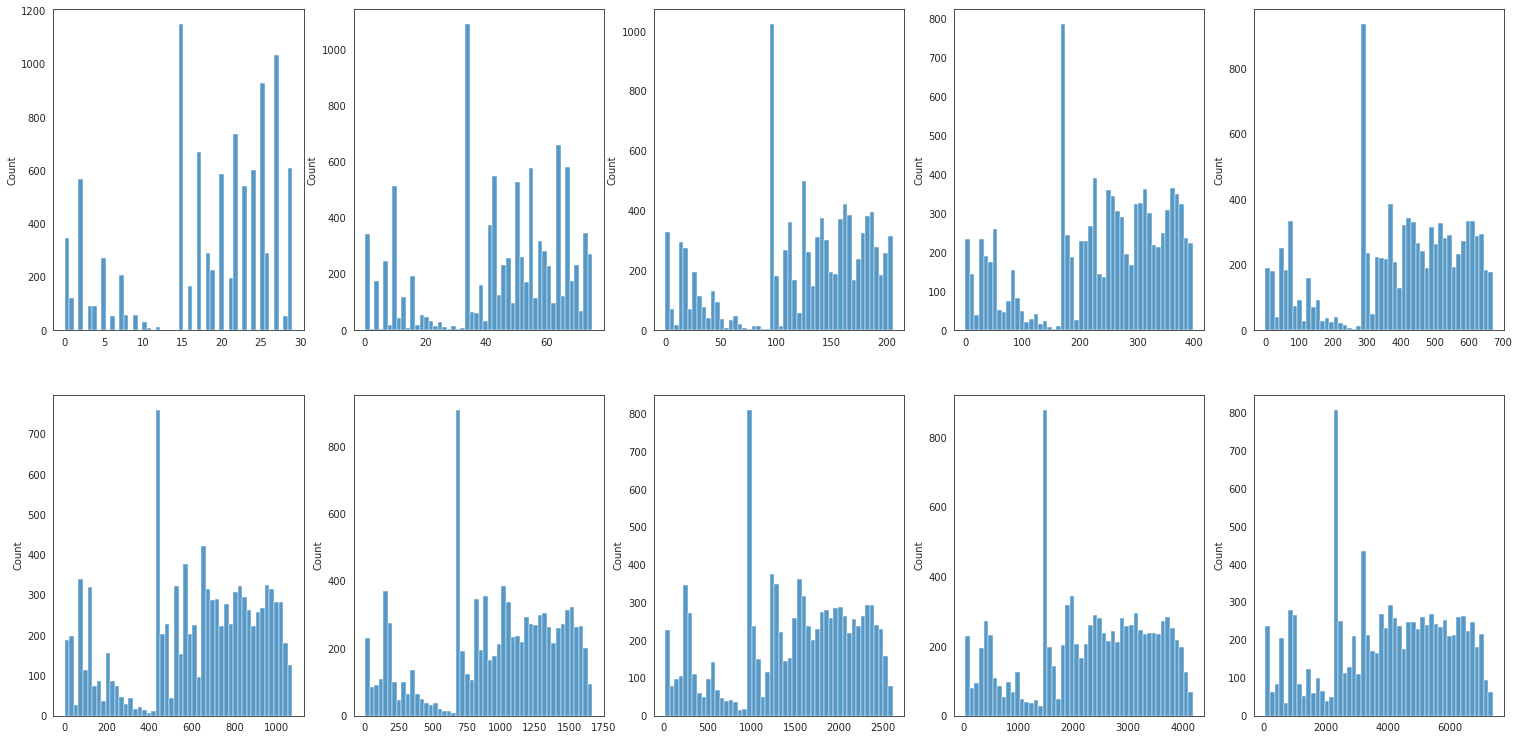

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [ ]:
count1

[0.0416221985058698,
 0.0768409818569904,
 0.14834578441835647,
 0.21664887940234792,
 0.2892209178228389,
 0.37726787620064034,
 0.47225186766275346,
 0.5688367129135539,
 0.6472785485592316,
 0.7219850586979722]

In [ ]:
count2

[18.429,
 44.7124,
 124.3739,
 237.4232,
 393.8676,
 625.658,
 966.4869,
 1474.9361,
 2306.5798,
 3980.026]

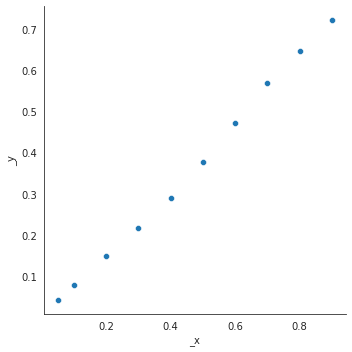

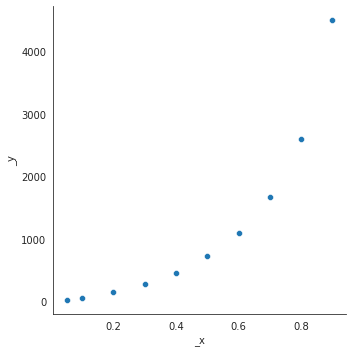

In [ ]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_typecloth)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

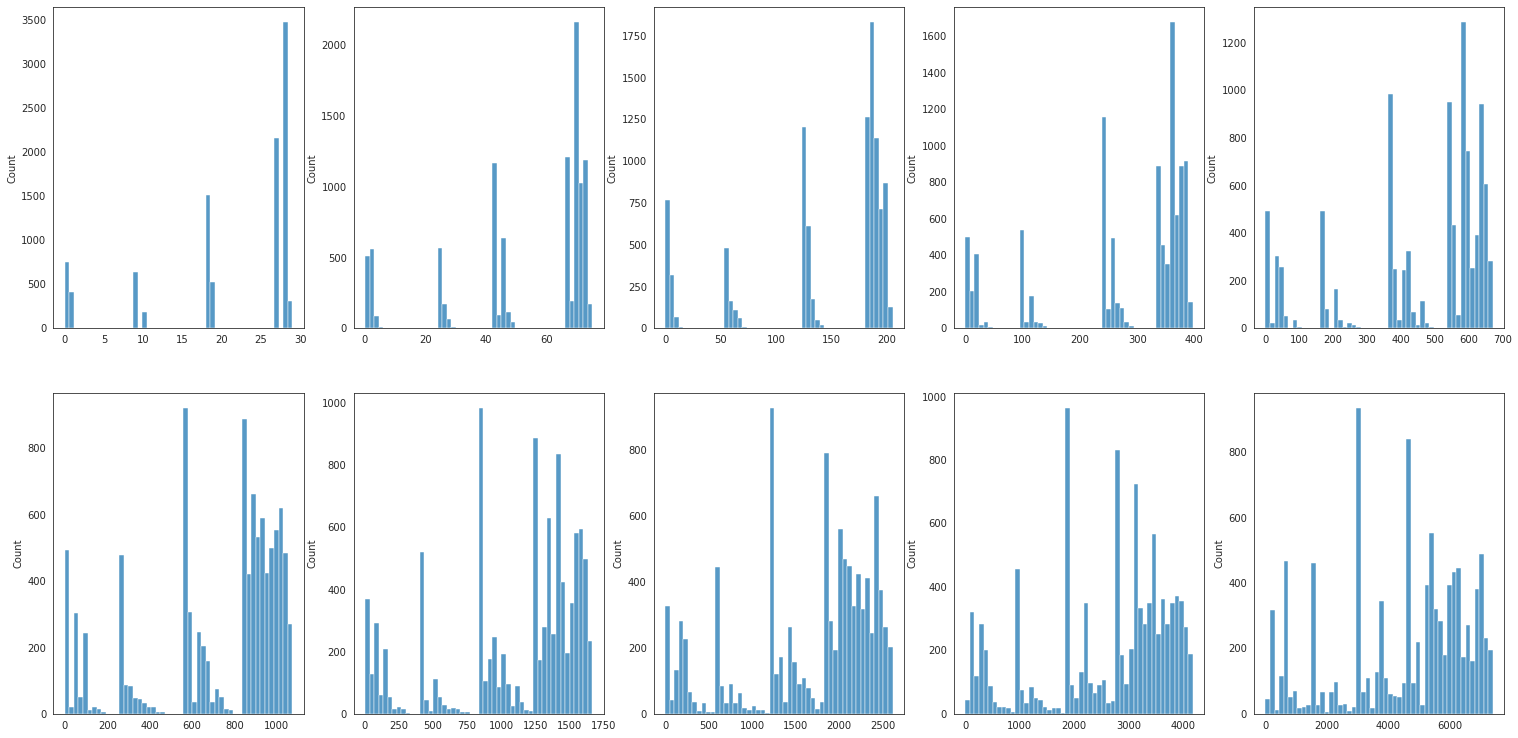

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [ ]:
count1

[0.0416221985058698,
 0.0768409818569904,
 0.14834578441835647,
 0.21664887940234792,
 0.2892209178228389,
 0.37726787620064034,
 0.47225186766275346,
 0.5688367129135539,
 0.6472785485592316,
 0.7219850586979722]

In [ ]:
count2

[21.0266,
 52.7877,
 143.9466,
 278.2008,
 457.1927,
 719.0321,
 1097.6784,
 1660.91,
 2593.8688,
 4499.4097]

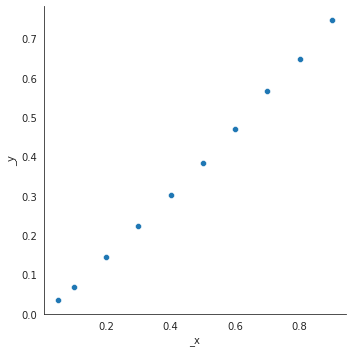

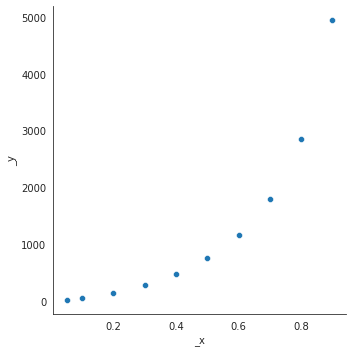

In [ ]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_appearance)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

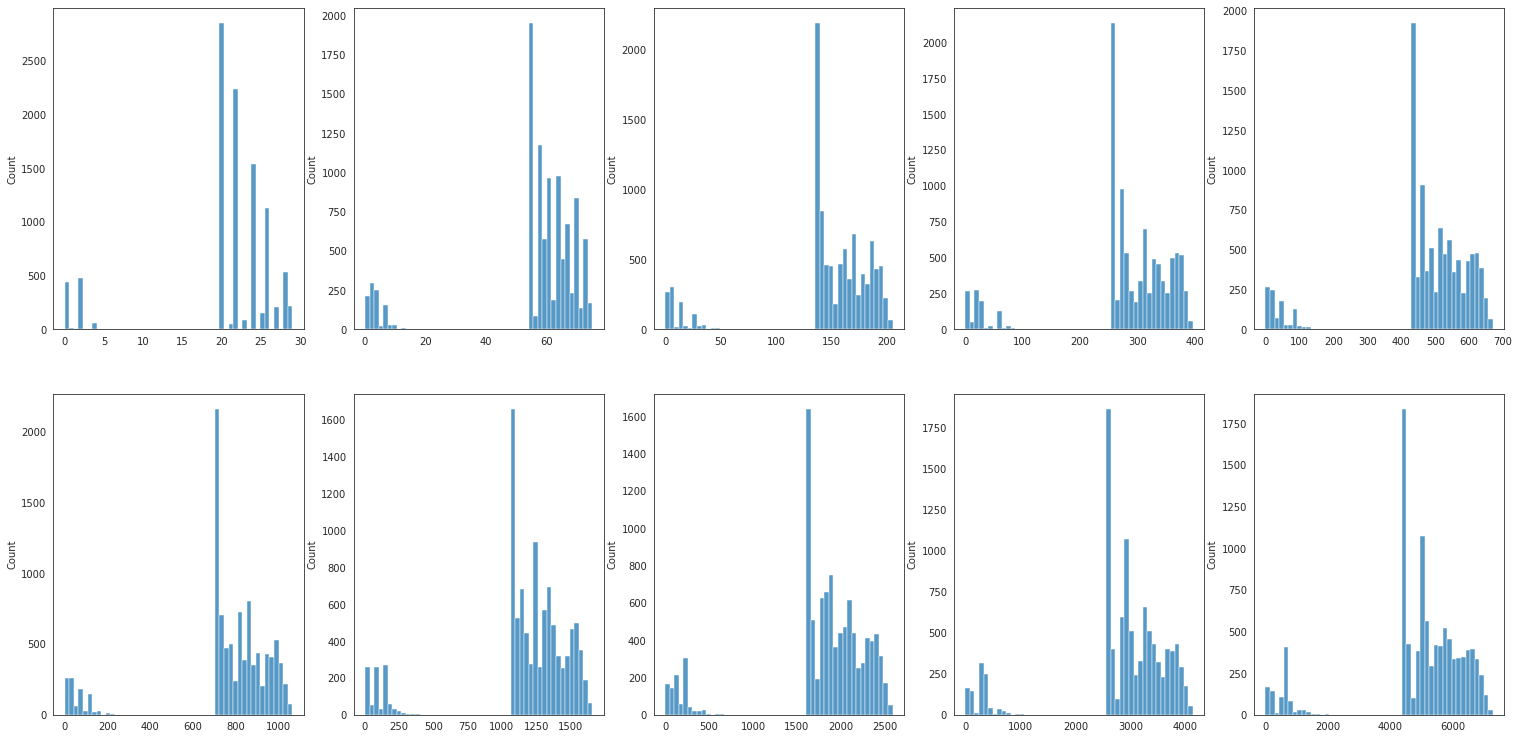

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [ ]:
count1

[0.03550640279394645,
 0.06868451688009314,
 0.14377182770663563,
 0.2240977881257276,
 0.30267753201396974,
 0.3841676367869616,
 0.46973224679860304,
 0.5657741559953434,
 0.6490104772991852,
 0.7462165308498254]

In [ ]:
count2

[20.7271,
 56.0863,
 145.4567,
 279.3143,
 470.5949,
 755.6025,
 1169.8446,
 1797.1264,
 2855.0558,
 4939.9009]

In [ ]:
# The method describe previously is not really accurate and the maximum accuracy
# c1 because the way it was calculated meant that if we covered all the category
# of a variable c1 was always the same. the intersection of most popular items
# selected with the threshold and the actual items purchased.
# we need to change the strategy to calculate c1 and we only have 491
# candidates the way we work. It would be better to have more.

In [ ]:
len(set(df_temp_Y['customer_id']))

491

# Revision of the strategy to limit potential articles for each customer

In [ ]:
# lets work the way around
# we randomly select 10 000 customers who bought something during the last week
# of data

In [574]:
customer_list = random.sample(set(df[df['t_dat']>'2020-09-14']['customer_id']),\
                              k=30000)

In [575]:
df_temp_Y = df[df['customer_id'].isin(customer_list)]
df_train = df_info[df_info['customer_id'].isin(customer_list)]
df_temp_Y = df_temp_Y[df_temp_Y['t_dat'] > '2020-09-14']

In [576]:
print(df_temp_Y.shape,df_train.shape)

(105029, 5) (1864177, 18)


In [577]:
sample_train_df = pd.DataFrame(index=customer_list)
sample_train_df['customer_id']=sample_train_df.index

In [578]:
sample_train_df['colour_bought'] = df_train.groupby('customer_id')\
['perceived_colour_master_name'].unique()
sample_train_df['nb_purchase'] = df_train.groupby('customer_id')\
['article_id'].count()
sample_train_df['type_of_clothing'] = df_train.groupby('customer_id')\
['product_group_name'].unique()
sample_train_df['appearance'] = df_train.groupby('customer_id')\
['graphical_appearance_name'].unique()
sample_train_df['wider_colour'] = df_train.groupby('customer_id')\
['perceived_colour_value_name'].unique()

In [579]:
sample_train_df['average_buy'] = df_train.groupby('customer_id')['price'].mean()
sample_train_df['std_buy'] = df_train.groupby('customer_id')['price'].std()
sample_train_df['max_budget'] = df_train.groupby('customer_id')['price'].max()

In [ ]:
df_3_weeks = df_info[(df_info['t_dat']>'2020-09-01')&(df_info['t_dat']<='2020-09-14')]

In [152]:
def art_sel_budget(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_train_df.loc[cust,'max_budget']] 
    temp_list1 = set(temp_list.index).intersection(set(actually_bought))
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))   

In [149]:
def art_sel_colour(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_train_df.loc[cust,'colour_bought']))]['article_id'])) 
    temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [150]:
def art_sel_typecloth(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    # we remove articles out of the product group of the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_train_df.loc[cust,'type_of_clothing']))]['article_id']))      
    temp_list1 = temp_list.intersection(set(actually_bought))    
    return(temp_list1,len(set(actually_bought)),len(temp_list))

In [151]:
def art_sel_appearance(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_train_df.loc[cust,'appearance']))]['article_id']))   
    temp_list1 = temp_list.intersection(set(actually_bought))   
    return(temp_list1,len(set(actually_bought)),len(temp_list))  

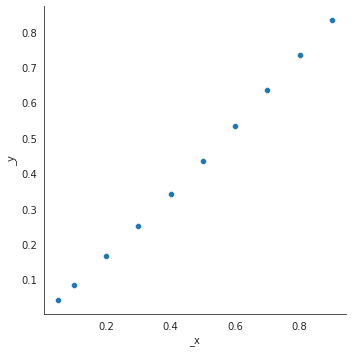

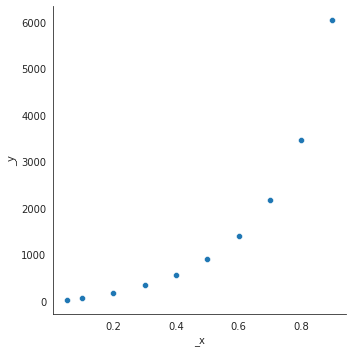

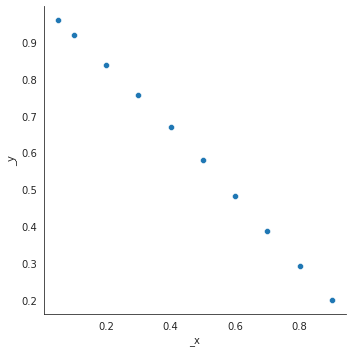

In [51]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_train_df['possible_good_guess'] = sample_train_df['customer_id'].apply(
      art_sel_appearance,)  
  c1 = 0
  c2 = 0 
  c3 = 0
  for i in sample_train_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]    
    c3 += i[1]       
  c2 = c2/len(sample_train_df['customer_id'])  
  count1.append(c1/c3)
  count2.append(c2)
  count3.append((1-c1/c3)*len(df_temp_Y['article_id'])/(len(df_temp_Y['article_id'])-c2))  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the remaining info multiplied by the max precision accessible
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)
sns.relplot(x=th_list,y=count3)

In [52]:
count1

[0.04282370801442217,
 0.08333860459232083,
 0.16576001012081726,
 0.25175532924283633,
 0.34217850591435256,
 0.43560630020874186,
 0.5351065848567271,
 0.6360933645391865,
 0.7359415522803466,
 0.832405591751534]

In [53]:
count2

[25.1212,
 64.5638,
 172.1774,
 333.9674,
 562.2366,
 904.9014,
 1401.4822,
 2167.3565,
 3462.8669,
 6040.1877]

In [54]:
count3

[0.9578548916162294,
 0.9183334984090212,
 0.8383105539552305,
 0.7553589510512873,
 0.6684199360099674,
 0.5791740202101011,
 0.48402398860569085,
 0.3875977281447516,
 0.29263687797608234,
 0.20200442021523615]

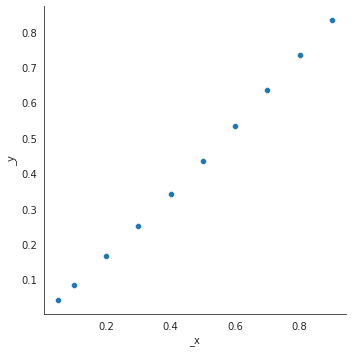

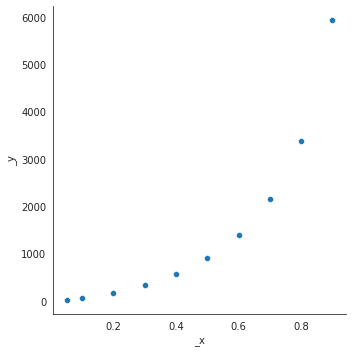

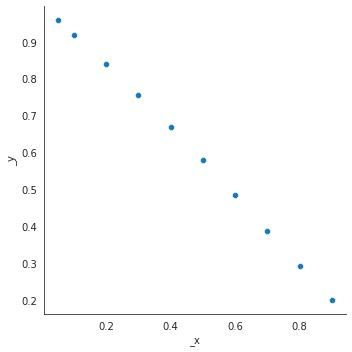

In [55]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_train_df['possible_good_guess'] = sample_train_df['customer_id'].apply(
      art_sel_typecloth)  
  c1 = 0
  c2 = 0  
  c3 = 0
  for i in sample_train_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]    
    c3 += i[1]       
  c2 = c2/len(sample_train_df['customer_id'])  
  count1.append(c1/c3)
  count2.append(c2)
  count3.append((1-c1/c3)*len(df_temp_Y['article_id'])/(len(df_temp_Y['article_id'])-c2))  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the remaining info multiplied by the max precision accessible
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)
sns.relplot(x=th_list,y=count3)

In [56]:
count1

[0.04282370801442217,
 0.08333860459232083,
 0.16576001012081726,
 0.25175532924283633,
 0.34217850591435256,
 0.43560630020874186,
 0.5351065848567271,
 0.6360933645391865,
 0.7359415522803466,
 0.832405591751534]

In [57]:
count2

[25.9458,
 65.7319,
 178.9442,
 346.8089,
 576.9551,
 912.3087,
 1402.6889,
 2146.2179,
 3383.3352,
 5924.3967]

In [58]:
count3

[0.9578771828683232,
 0.9183638065839107,
 0.8384713439462854,
 0.7556352067239197,
 0.6687019762073345,
 0.5792982033245605,
 0.4840411387822128,
 0.38735177830749196,
 0.29191128402399286,
 0.20121245786573194]

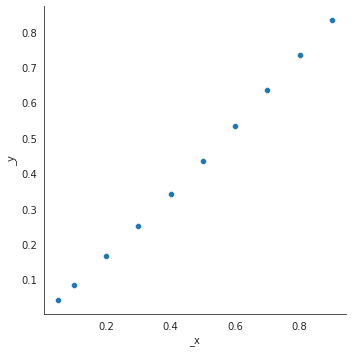

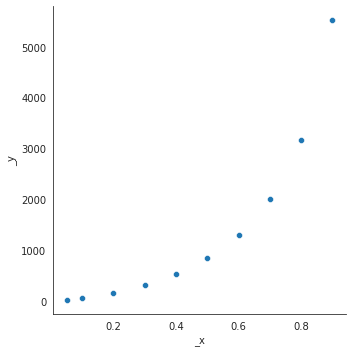

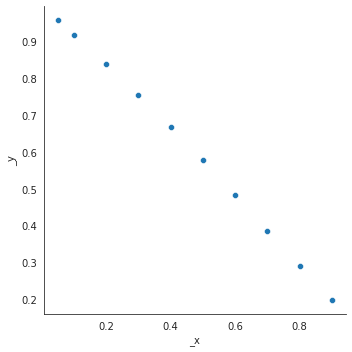

In [59]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_train_df['possible_good_guess'] = sample_train_df['customer_id'].apply(
      art_sel_colour)  
  c1 = 0
  c2 = 0  
  c3 = 0
  for i in sample_train_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]    
    c3 += i[1]       
  c2 = c2/len(sample_train_df['customer_id'])  
  count1.append(c1/c3)
  count2.append(c2)
  count3.append((1-c1/c3)*len(df_temp_Y['article_id'])/(len(df_temp_Y['article_id'])-c2))  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the remaining info multiplied by the max precision accessible
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)
sns.relplot(x=th_list,y=count3)

In [60]:
count1

[0.04282370801442217,
 0.08333860459232083,
 0.16576001012081726,
 0.25175532924283633,
 0.34217850591435256,
 0.43560630020874186,
 0.5351065848567271,
 0.6360933645391865,
 0.7359415522803466,
 0.832405591751534]

In [61]:
count2

[23.9494,
 59.3701,
 164.711,
 316.7533,
 528.7952,
 839.7707,
 1301.2723,
 2005.0012,
 3163.4382,
 5518.4898]

In [62]:
count3

[0.9578232163584551,
 0.9181987639865381,
 0.8381332118951581,
 0.7549889455524842,
 0.6677800056523853,
 0.5780843942963868,
 0.4826039879568837,
 0.3857166811043523,
 0.2899236915485765,
 0.19848459770342716]

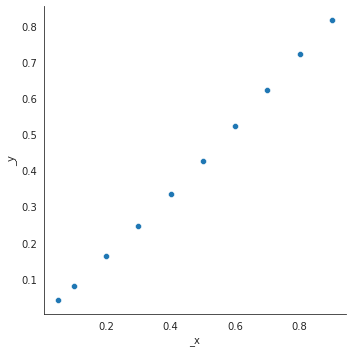

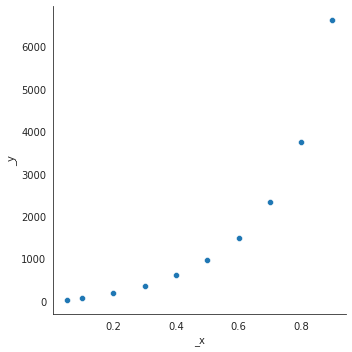

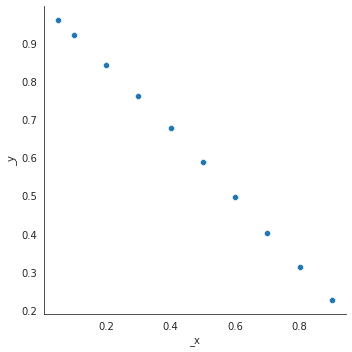

In [101]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  wide_list_popular_item_df['price_estimated'] = 0
  for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers. We divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list. we calculate c2 the number of articles
  # in our restricted list on average we calculate c3, the distribution of
  # of number of restricted articles per customer.
  sample_train_df['possible_good_guess'] = sample_train_df['customer_id'].apply(
      art_sel_budget)  
  c1 = 0
  c2 = 0  
  c3 = 0
  for i in sample_train_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]    
    c3 += i[1]       
  c2 = c2/len(sample_train_df['customer_id'])  
  count1.append(c1/c3)
  count2.append(c2)
  count3.append((1-c1/c3)*len(df_temp_Y['article_id'])/(len(df_temp_Y['article_id'])-c2))  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)
sns.relplot(x=th_list,y=count3)

In [102]:
count1

[0.042191156935922576,
 0.08172559934214688,
 0.16224935163514453,
 0.24641027262951484,
 0.33499905117338225,
 0.4266557024479727,
 0.5237839205515845,
 0.622999557214245,
 0.7206338161806566,
 0.8148206717692453]

In [103]:
count2

[27.0709,
 68.7467,
 184.0529,
 357.9926,
 603.5296,
 961.849,
 1484.2122,
 2333.6404,
 3739.9575,
 6617.8353]

In [104]:
count3

[0.9585406335160318,
 0.9200581780782794,
 0.8421217516260829,
 0.7612755337281297,
 0.6765155762879345,
 0.5893302738796411,
 0.497019909603714,
 0.4035596552660544,
 0.3123059440413467,
 0.2276702022278015]

In [628]:
def art_sel_budget_f(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = set(temp_list[temp_list['price_estimated']<sample_train_df.loc[cust,'max_budget']]) 
    # temp_list1 = set(temp_list.index).intersection(set(actually_bought))
    return(temp_list)   

In [164]:
def art_sel_colour_f(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_train_df.loc[cust,'colour_bought']))]['article_id'])) 
    # temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(temp_list)

In [165]:
def art_sel_typecloth_f(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df  
    # we remove articles out of the product group of the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_train_df.loc[cust,'type_of_clothing']))]['article_id']))      
    # temp_list1 = temp_list.intersection(set(actually_bought))    
    return(temp_list)

In [166]:
def art_sel_appearance_f(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df  
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_train_df.loc[cust,'appearance']))]['article_id']))   
    # temp_list1 = temp_list.intersection(set(actually_bought))   
    return(temp_list)  

In [595]:
def art_sel_wider_colour_f(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['perceived_colour_value_name'].isin(set(sample_train_df.loc[cust,'wider_colour']))]['article_id'])) 
    # temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(temp_list)

In [580]:
def purchased(cust):
  return(set(df_temp_Y[df_temp_Y['customer_id']==cust]['article_id'])) 
sample_train_df['purchased'] = sample_train_df['customer_id'].apply(purchased)

In [ ]:
nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<0.06).sum() 
wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
def final_list(cust):  
  list_art = set(wide_list_popular_item_df.index)
  if len(list_art)>12:
    list_art = art_sel_wider_colour_f(cust,list_art)
    if(len(list_art))>12:
      list_art = art_sel_typecloth_f(cust,list_art)
      if(len(list_art))>12:
        list_art = art_sel_appearance_f(cust,list_art)
  return(list_art)

In [639]:
nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<0.1).sum() 
wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
wide_list_popular_item_df['price_estimated'] = 0
for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
def final_list(cust):  
  list_art = set(wide_list_popular_item_df.index)
  if len(list_art)>12:
    list_art = art_sel_budget_f(cust,list_art)
    if len(list_art)>12:
      list_art = art_sel_colour_f(cust,list_art)
      if(len(list_art))>12:
        list_art = art_sel_typecloth_f(cust,list_art)
        if(len(list_art))>12:
          list_art = art_sel_appearance_f(cust,list_art)
  return(list_art)



In [640]:
t0 = time()
sample_train_df['list_art'] = sample_train_df['customer_id'].apply(final_list)
t1 = time()
print(t1-t0)

9.633281707763672


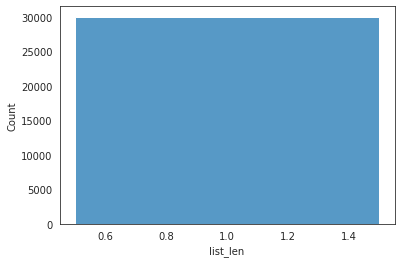

In [641]:
sample_train_df['list_len'] = sample_train_df['list_art'].apply(len)
sns.histplot(sample_train_df['list_len'])


In [642]:
sample_train_df['list_len'].mean()

1.0

In [643]:
t0=time()
df_X = sample_train_df.copy()
df_art_in_range = pd.DataFrame()
for count,cust in enumerate(df_X.index):             
      article_in_range = list(df_X.loc[cust,'list_art'])
      df_art_in_range_bis = pd.DataFrame(index=article_in_range)
      df_art_in_range_bis['article_id'] = article_in_range
      df_art_in_range_bis['customer_id'] = cust 
      df_art_in_range = pd.concat([df_art_in_range,df_art_in_range_bis],axis=0)     
df_X = df_X.merge(df_art_in_range,how='outer',on='customer_id')
t1=time()
print(t1-t0)

58.68539118766785


In [644]:
def final_draw(art_list):
  if len(art_list)>=12:
    final_list = random.sample(art_list,k=12)
    # print(final_list)
    return(final_list)
  else:
    a = random.sample(art_list^set(most_bought_2020.index),k=(12-len(art_list)))
    final_list = art_list.union(set(a))
    return(final_list)    

In [645]:
sample_train_df['final'] = sample_train_df['list_art'].apply(final_draw)

In [646]:
sample_train_df['len'] = sample_train_df['final'].apply(len)

In [647]:
sample_train_df['results'] =0
for cust in sample_train_df.index:
  a = set(sample_train_df.loc[cust,'purchased'])
  b = set(sample_train_df.loc[cust,'final'])
  sample_train_df.loc[cust,'results'] = len(a.intersection(b))/len(a)

In [648]:
sample_train_df['results'].mean()

0.022231284429090628

In [649]:
# list of customer who never bought anything
never_bought =set(meta_cust['customer_id'])^set(df['customer_id'])

In [306]:
b =set(df['customer_id'])
cust_df = pd.DataFrame(index=b)
cust_df['customer_id'] = list(b)
cust_df['colour_bought'] = 0
cust_df['type_of_clothing'] = 0
cust_df['appearance'] = 0
cust_df['colour_bought'] = df_info.groupby('customer_id')\
['perceived_colour_master_name'].unique()
cust_df['type_of_clothing'] = df_info.groupby('customer_id')\
['product_group_name'].unique()
cust_df['appearance'] = df_info.groupby('customer_id')\
['graphical_appearance_name'].unique()

In [563]:
df_3_weeks_final = df_info[(df_info['t_dat']>'2020-09-08')]
nb = (df_3_weeks_final['article_id'].value_counts(normalize=True).cumsum()<0.06).sum() 
wide_list_popular_items = df_3_weeks_final['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]

In [ ]:
def art_sel_budget_final(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_train_df.loc[cust,'max_budget']] 
    temp_list1 = set(temp_list.index).intersection(set(actually_bought))
    return(temp_list)   

In [300]:
def art_sel_colour_final(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(cust_df.loc[cust,'colour_bought']))]['article_id'])) 
    # temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(temp_list)

In [301]:
def art_sel_typecloth_final(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df  
    # we remove articles out of the product group of the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(cust_df.loc[cust,'type_of_clothing']))]['article_id']))      
    # temp_list1 = temp_list.intersection(set(actually_bought))    
    return(temp_list)

In [302]:
def art_sel_appearance_final(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df  
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(cust_df.loc[cust,'appearance']))]['article_id']))   
    # temp_list1 = temp_list.intersection(set(actually_bought))   
    return(temp_list)  

In [ ]:
def art_sel_appearance_final(cust,temp_list): 
    # actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    # temp_list = wide_list_popular_item_df  
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(cust_df.loc[cust,'appearance']))]['article_id']))   
    # temp_list1 = temp_list.intersection(set(actually_bought))   
    return(temp_list)  

In [564]:
nb = (df_3_weeks_final['article_id'].value_counts(normalize=True).cumsum()<0.06).sum() 
wide_list_popular_items = df_3_weeks_final['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
def final_list(cust):  
  list_art = set(wide_list_popular_item_df.index)
  if len(list_art)>12:
    list_art = art_sel_colour_final(cust,list_art)
    if(len(list_art))>12:
      list_art = art_sel_typecloth_final(cust,list_art)
      if(len(list_art))>12:
        list_art = art_sel_appearance_final(cust,list_art)
  return(list_art)

In [565]:
t0 = time()
cust_df['list_art'] = cust_df['customer_id'].apply(final_list)
t1 = time()
print(t1-t0)

1529.0491127967834


In [566]:
def final_draw(art_list):
  if len(art_list)>=12:
    final_list = random.sample(art_list,k=12)
    # print(final_list)
    return(final_list)
  else:
    a = random.sample(art_list^set(most_bought_2020.index),k=(12-len(art_list)))
    final_list = art_list.union(set(a))
    return(final_list)

In [567]:
def final_draw(art_list):
  if len(art_list)>=12:
    final_list = random.sample(art_list,k=12)
    # print(final_list)
    return(final_list)
  else:  
    a = set(most_bought_2020.index).difference(art_list)
    a = random.sample(a,k=(12-len(art_list)))     
    final_list = art_list.union(set(a))    
    return(final_list)
    

In [568]:
t0 = time()
cust_df['final'] = cust_df['list_art'].apply(final_draw)
t1 = time()
print(t1-t0)

24.198362588882446


In [569]:
cust_df['len'] = cust_df['final'].apply(len)

In [570]:
cust_df['len'].value_counts()

12    1362281
Name: len, dtype: int64

In [571]:
def submission(cust):
  if cust in never_bought:
    return(' '.join(most_bought_2020.index.tolist()))
  else:
    return(' '.join(cust_df.loc[cust,'final']))

In [572]:
sub_format['prediction'] = sub_format['customer_id'].apply(submission)

In [390]:
sub_format.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0673677002 0915526001 0863646001 0714790020 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0914805002 0915526001 0898694001 0863595006 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0894780001 0751471001 0673677002 0706016003 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0762846006 0863595006 0751471001 0809238001 06...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0919273002 0863646001 0915529003 0809238005 09...


In [573]:
sub_format.to_csv('final_submission_1.csv',index=False)